# Clean dataset using influence functions and neural networks


This notebook cares about how to fit a neural network to some data and determine the most influential points. Consider a simple dataset with

$$
\begin{align*}
x &\sim \mathsf{U}(-1, 1) \in \mathbb{R}^d \\
\mu &= \sin(x_1)^2 \sin(x_2)^2 + 0.01 x_1^3 \cos(x_1)^2 \\
y &\sim \mathcal{N} \left (\mu, 0.3 \right )
\end{align*}
$$

repetitive characteristics. The intuition behind choosing this dataset is that it is the same regression pattern getting higher repsonse the further one moves it the right. Generating this dataset is as simply as

In [1]:
import numpy as np
num_samples = 10000
d = 2
w = 8
x = np.random.uniform(-w, w, size=[num_samples, d])
x1, x2 = x[:, 0], x[:, 1]
mus = 1 / 3 * x1 ** 3 + x2 ** 2
sigma = 0.3
y = mus + np.random.normal(0, sigma, size=num_samples)

In [2]:
from sklearn.model_selection import train_test_split
from valuation.utils import Dataset

arg_flipper = lambda x1, x2, y1, y2: (x1, y1, x2, y2) # hacky
dataset = Dataset(*arg_flipper(*train_test_split(x, y, train_size=0.70)))

is straightforward using python. As usual a closer inspection of the data is helpful. The data is plotted by the following function.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


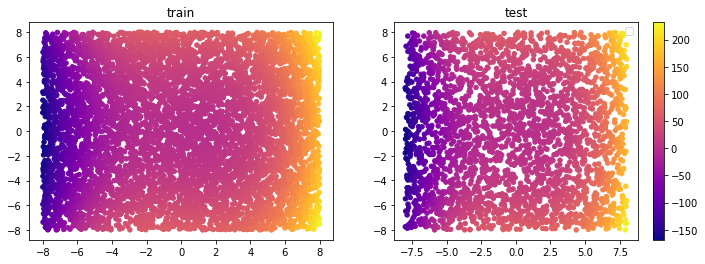

In [3]:
from valuation.utils.plotting import plot_datasets

datasets = {
    'train': (dataset.x_train, dataset.y_train),
    'test': (dataset.x_test, dataset.y_test)
}
plot_datasets(datasets, s=20)

## Fit a neural network to the data

First, a 2-layer neural network is created and fitted with pyDVL.

In [10]:
from copy import copy
from valuation.models.neural_network_torch_model import NNTorchModel
from valuation.models.pytorch_model import PyTorchSupervisedModel, PyTorchOptimizer
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler

x_transformer = MinMaxScaler()
y_transformer = MinMaxScaler()

transformed_dataset = copy(dataset)
transformed_dataset.x_train = x_transformer.fit_transform(transformed_dataset.x_train)
transformed_dataset.y_train = y_transformer.fit_transform(dataset.y_train.reshape([-1, 1]))[:, 0]
transformed_dataset.x_test = x_transformer.transform(transformed_dataset.x_test)
transformed_dataset.y_test = y_transformer.transform(dataset.y_test.reshape([-1, 1]))[:, 0]

model = PyTorchSupervisedModel(
    model=NNTorchModel(d, 1, [16, 16, 16]),
    objective=F.mse_loss,
    num_epochs=100,
    batch_size=128,
    optimizer=PyTorchOptimizer.ADAM,
    optimizer_kwargs={
        "lr": 0.001,
        "weight_decay": 0.01
    },
)
model.fit(
    transformed_dataset.x_train,
    transformed_dataset.y_train
)

Training loss: 0.14627961814403534
Training loss: 0.1389029622077942
Training loss: 0.14782629907131195
Training loss: 0.12298784404993057
Training loss: 0.11050362884998322
Training loss: 0.11523454636335373
Training loss: 0.11779841780662537
Training loss: 0.11445173621177673
Training loss: 0.09790506213903427
Training loss: 0.09563209116458893
Training loss: 0.08893493562936783
Training loss: 0.08519966900348663
Training loss: 0.07893998920917511
Training loss: 0.07815191894769669
Training loss: 0.06942816823720932
Training loss: 0.07629039883613586
Training loss: 0.060978442430496216
Training loss: 0.05576780438423157
Training loss: 0.04937009885907173
Training loss: 0.05647432804107666
Training loss: 0.04921538382768631
Training loss: 0.043429985642433167
Training loss: 0.04081644490361214
Training loss: 0.034441690891981125
Training loss: 0.03349170461297035
Training loss: 0.02935926988720894
Training loss: 0.030280085280537605
Training loss: 0.02744884602725506
Training loss: 0.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


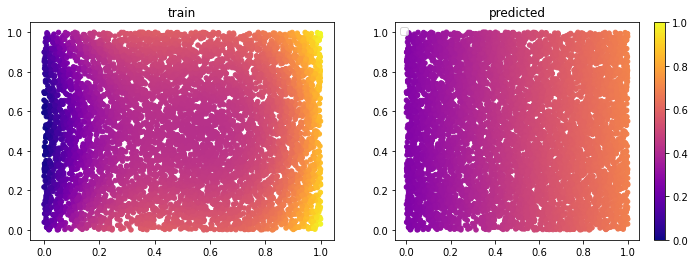

In [12]:
pred_y = model.predict(transformed_dataset.x_train)
datasets = {
    'train': (transformed_dataset.x_train, transformed_dataset.y_train),
    'predicted': (transformed_dataset.x_train, pred_y)
}
plot_datasets(datasets, s=20)